## 1 Functions and module

### 1.1 Modules

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec
import numpy as np
import math
import seaborn as sns
import re
import scipy.stats as SS
%matplotlib inline 
import copy

In [2]:
pd.set_option('display.max_columns', None)

### 1.2 Functions

In [3]:
def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x']+.02, point['y'], str(point['val']),size = 8)

In [4]:
def LN_Mean(input_vector):
    log_vector = np.log(input_vector)
    temp_mean = log_vector.mean()
    temp_var = log_vector.var()
    return (math.exp(temp_mean + 0.5*temp_var))

----

## 2 Input and output address

In [5]:
data_dir = "data/"
# Oncogene negative data full data
TKO_data_address = data_dir + 'Ca12a_TKO_final_df.parquet'
# PDAC data full data
PDAC_data_address = data_dir + 'Ca12a_PDAC_final_df.parquet'
# SCLC negative data
SCLC_data_address = data_dir + 'Ca12a_SCLC_final_df.parquet'

---

## 3 Raw data processing

### 3.1 Read Data for TKO

In [6]:
TKO_df = pd.read_parquet(TKO_data_address)

In [8]:
#  I rename Tomato cas12a into Cas12a for the simplicity 
TKO_df.loc[TKO_df.Mouse_genotype.str.contains('Cas12a'),'Mouse_genotype'] = 'Cas12a'

### 3.2 Read Data for SCLC

In [9]:
SCLC_df = pd.read_parquet(SCLC_data_address)

### 3.3 Read Data for PDAC

In [59]:
PDAC_df = pd.read_parquet(PDAC_data_address)

In [60]:
PDAC_df.loc[PDAC_df.Mouse_genotype=='Kras/+;Tomato/+;LSL-Cas12a/+','Mouse_genotype'] = 'Kras_Cas12aHET'

In [61]:
PDAC_df.loc[PDAC_df.Mouse_genotype=='LSL-Cas12a','Mouse_genotype'] = 'Cas12a'

In [62]:
# Correct mice genotype
tt_list = []
for x,y in zip(PDAC_df.Sample_ID.to_list(),PDAC_df.Mouse_genotype.to_list()):
    if x == 'LA75_70':
        temp = 'Cas12a'
    elif x == 'LA75_74':
        temp = 'Kras_Cas12aHET'
    else:
        temp=y
    tt_list.append(temp)

PDAC_df.Mouse_genotype = tt_list

### 3.4 Virus titer dictionary

In [63]:
virus_dic = {'KT':2, 'TKO':2, 'Cas12a':10, 'Kras_Cas12aHET':10}

---

## 4 Plotting for Oncogene negative

<font size="10" color="red"> Fig. 3(b-d)</font>

### 4.1 Datat processing

In [15]:
input_df = TKO_df
cell_cutoff = 300
input_tissue = 'Lung'
Filtered_input_df = input_df[(input_df.Class=='Original')&(input_df.Cell_number>cell_cutoff)&(input_df.Tissue=='Lung')&(~input_df.Sample_ID.str.contains('B'))].copy()
temp_dic = virus_dic

In [16]:
Input_df = input_df[(input_df.Count>1)&(input_df.Class=='Original')]
CT_df = Input_df.groupby(['Sample_ID','Clonal_barcode'],as_index=False)['gRNA_combination'].count()
CT_df = CT_df[CT_df.gRNA_combination>1]
CT_df_s = CT_df.groupby(['Sample_ID'],as_index=False)['Clonal_barcode'].count().rename(columns={'Clonal_barcode':'Clonal_barcode_special'})

In [17]:
CT_df = Input_df.groupby(['Sample_ID','Clonal_barcode'], as_index=False).agg(
    gRNA_combination=pd.NamedAgg(column='gRNA_combination', aggfunc=lambda x: len(x)),
    Total_read_count = pd.NamedAgg(column='Count', aggfunc=lambda x: np.sum(x))
)
CT_df = CT_df[CT_df.gRNA_combination>1]

In [18]:
CT_df_s = CT_df.groupby(['Sample_ID'],as_index=False).agg(
    Clonal_barcode_special=pd.NamedAgg(column='Clonal_barcode', aggfunc=lambda x: len(x)),
    Total_read_count_special = pd.NamedAgg(column='Total_read_count', aggfunc=lambda x: np.sum(x))
)

In [19]:
Barcode_s_df = Input_df.groupby(['Sample_ID'],as_index=False).agg(
    Clonal_barcode=pd.NamedAgg(column='Clonal_barcode', aggfunc=lambda x: len(x.unique())),
    Total_read_count = pd.NamedAgg(column='Count', aggfunc=lambda x: np.sum(x))
)

In [20]:
Barcode_s_df = Barcode_s_df.merge(CT_df_s,on='Sample_ID')
Barcode_s_df['Ratio_number'] = Barcode_s_df.Clonal_barcode_special/Barcode_s_df.Clonal_barcode
Barcode_s_df['Ratio_count'] = Barcode_s_df.Total_read_count_special/Barcode_s_df.Total_read_count

In [21]:
Barcode_s_df

,Sample_ID,Clonal_barcode,Total_read_count,Clonal_barcode_special,Total_read_count_special,Ratio_number,Ratio_count
0,LA75_60,167778,6351400,13105,1066992,0.078109,0.167993
1,LA75_61,138270,6077194,8966,865160,0.064844,0.142362
2,LA75_62,108533,5686240,5878,739454,0.054159,0.130043
3,LA75_63,123006,7174886,7243,957458,0.058883,0.133446
4,LA75_64,57904,6500268,1692,477759,0.029221,0.073498
5,LA75_65,132412,6401679,8277,938132,0.062509,0.146545
6,LA75_66,66350,512788,2192,50009,0.033037,0.097524
7,LA75_67,75088,690440,2714,83948,0.036144,0.121586
8,LA75_68,125704,1703731,8412,404551,0.066919,0.237450
9,LA75_69,93891,1456542,4703,245452,0.050090,0.168517


### 4.2 Plotting

 <font size="5" color='red'> I extroplate tumor number and burden </font>
 
 <font size="5" color='red'> I always need to consider the virus titer and used lung weight </font>

In [22]:
temp_df = copy.deepcopy(Filtered_input_df)
temp_summary_df = temp_df.groupby(['Sample_ID','Mouse_genotype'],as_index=False).agg(
        Total_tumor_number = pd.NamedAgg('Clonal_barcode',aggfunc ='count'),
        TTB = pd.NamedAgg('Cell_number',aggfunc = np.sum),
        LN_mean_tumor_size = pd.NamedAgg('Cell_number',aggfunc = LN_Mean),
        Median_tumor_size = ('Cell_number',lambda x: np.median(x)),
        P95_tumor_size = ('Cell_number',lambda x: np.percentile(x,95))
)
temp = temp_df[['Sample_ID','Total_lung_weight','Lung_sample_weight']].drop_duplicates()

# factor into the fact that frozen tissue weight and total lung weight is different
temp_fold_dic = dict(zip(temp.Sample_ID,temp.Total_lung_weight/temp.Lung_sample_weight))
temp_summary_df['Total_tumor_number'] = temp_summary_df.apply(lambda x: x['Total_tumor_number']*temp_fold_dic.get(x['Sample_ID']),axis=1)
temp_summary_df['TTB'] = temp_summary_df.apply(lambda x: x['TTB']*temp_fold_dic.get(x['Sample_ID']),axis=1)

In [23]:
# normalize to per 100K virus
temp_summary_df['Tumor number per 100K virus'] = temp_summary_df.apply(lambda x: x['Total_tumor_number']/temp_dic.get(x['Mouse_genotype']),axis=1)
temp_summary_df['Total tumor burden per 100K virus (log10)'] = np.log10(temp_summary_df.apply(lambda x: x['TTB']/temp_dic.get(x['Mouse_genotype']),axis=1))

In [24]:
temp_summary_df.head()

,Sample_ID,Mouse_genotype,Total_tumor_number,TTB,LN_mean_tumor_size,Median_tumor_size,P95_tumor_size,Tumor number per 100K virus,Total tumor burden per 100K virus (log10)
0,LA75_60,Cas12a,258722.285319,9.909991e+08,3602.152732,1624.548736,14079.422383,25872.228532,7.996073
1,LA75_61,Cas12a,113299.000000,5.256789e+08,4219.093915,1403.508772,18508.771930,11329.900000,7.720721
2,LA75_62,Cas12a,155031.840491,6.164377e+08,3606.241561,1523.151909,14439.480097,15503.184049,7.789889
3,LA75_63,Cas12a,194398.945111,8.321925e+08,3527.703540,1113.736078,18022.274722,19439.894511,7.920224
4,LA75_64,Cas12a,60765.657331,2.381109e+08,3611.735578,1587.301587,13924.963925,6076.565733,7.376779


Text(0.0, 1.0, 'D')

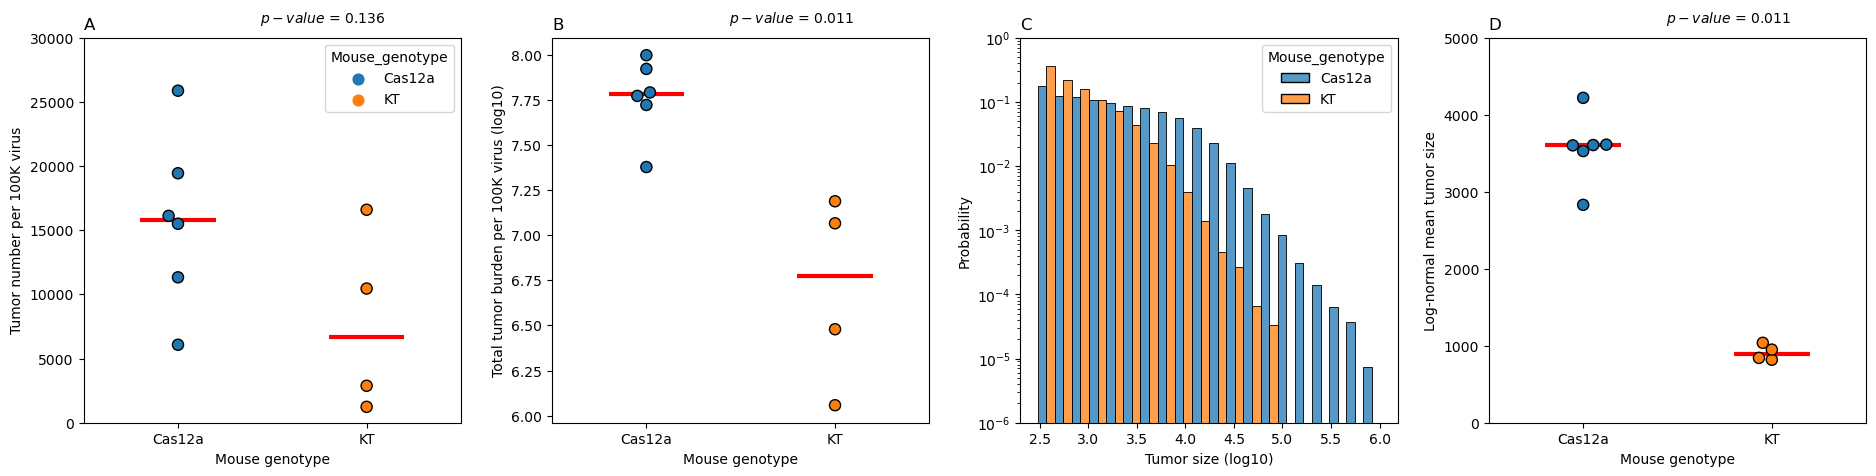

In [25]:
gs = gridspec.GridSpec(10, 23) 
fig1 = plt.figure(figsize=(23,5))
ax1=fig1.add_subplot(gs[:10, 0:5])
temp_p_df = temp_summary_df
ix = 'Mouse_genotype'
iy = 'Tumor number per 100K virus'
# panel A
# dot plot
sns.swarmplot(x=ix, y=iy, data=temp_p_df,
              ax=ax1, size=8,hue='Mouse_genotype',edgecolor="black", linewidth=1)

# add mean line
category_means = temp_p_df.groupby(ix)[iy].median().reset_index()
# Loop through each category and draw a horizontal line for its mean
for index, row in category_means.iterrows():
    # Get the positions of the x-ticks
    xticks = ax1.get_xticks()
    if row[ix] in temp_p_df[ix].values:
        # Find the position of the current category in the x-ticks
        ix_position = list(temp_p_df[ix].unique()).index(row[ix])
        # Draw a horizontal line for this category's mean
        ax1.hlines(row[iy], xticks[ix_position] - 0.2, xticks[ix_position] + 0.2, color='r', linestyle='-',linewidth=3)

# set labels
ax1.set_ylabel('Tumor number per 100K virus')
ax1.set_xlabel('Mouse genotype')
da1 = temp_p_df[temp_p_df.Mouse_genotype=='Cas12a'][iy].to_list()
da2 = temp_p_df[temp_p_df.Mouse_genotype=='KT'][iy].to_list()
temp = SS.ranksums(da1,da2)
# temp = SS.ttest_ind(da1, da2)
ax1.text(0.8,1.05, "$\it{p-value}$ =" + f" {temp[1]:.3f}", size=10, ha="right",verticalalignment='center', transform=ax1.transAxes)
ax1.set_ylim(0,30000)
ax1.set_title('A', loc ='Left')
# ax1.get_legend().set_visible(False)

# panel B
ax1=fig1.add_subplot(gs[:10, 6:11])
ix = 'Mouse_genotype'
iy = 'Total tumor burden per 100K virus (log10)'
sns.swarmplot(x=ix, y=iy, data=temp_p_df,
              ax=ax1, size=8,hue='Mouse_genotype',edgecolor="black", linewidth=1)
# add mean line
category_means = temp_p_df.groupby(ix)[iy].median().reset_index()
# Loop through each category and draw a horizontal line for its mean
for index, row in category_means.iterrows():
    # Get the positions of the x-ticks
    xticks = ax1.get_xticks()
    if row[ix] in temp_p_df[ix].values:
        # Find the position of the current category in the x-ticks
        ix_position = list(temp_p_df[ix].unique()).index(row[ix])
        # Draw a horizontal line for this category's mean
        ax1.hlines(row[iy], xticks[ix_position] - 0.2, xticks[ix_position] + 0.2, color='r', linestyle='-',linewidth=3)
# labels
ax1.set_ylabel('Total tumor burden per 100K virus (log10)')
ax1.set_xlabel('Mouse genotype')
da1 = temp_p_df[temp_p_df.Mouse_genotype=='Cas12a'][iy].to_list()
da2 = temp_p_df[temp_p_df.Mouse_genotype=='KT'][iy].to_list()
temp = SS.ranksums(da1,da2)
# temp = SS.ttest_ind(da1, da2)
ax1.text(0.8,1.05, "$\it{p-value}$ =" + f" {temp[1]:.3f}", size=10, ha="right",verticalalignment='center', transform=ax1.transAxes)
# ax1.set_ylim(0,10)
ax1.set_title('B', loc ='Left')
ax1.get_legend().set_visible(False)

# panel C
ax1=fig1.add_subplot(gs[:10, 12:17])
temp_p_df3 = Filtered_input_df.copy()
temp_p_df3['Log10_CN'] = np.log10(temp_p_df3['Cell_number'] )
ix = 'Log10_CN'
sns.histplot(data=temp_p_df3, x=ix, hue="Mouse_genotype", bins=20,
                  common_norm=False, stat="probability", multiple="dodge", log_scale=(False, True),ax=ax1)
ax1.set_ylim(1e-6,1)
# ax1.get_legend().set_visible(False) 
ax1.set_xlabel('Tumor size (log10)')
ax1.set_ylabel('Probability')
ax1.set_title('C', loc ='Left')

# # panel D
ax1=fig1.add_subplot(gs[:10, 18:23])
ix = 'Mouse_genotype'
iy = 'LN_mean_tumor_size'

sns.swarmplot(x=ix, y=iy, data=temp_p_df,
              ax=ax1, size=8,hue='Mouse_genotype',edgecolor="black", linewidth=1)
# add mean line
category_means = temp_p_df.groupby(ix)[iy].median().reset_index()
# Loop through each category and draw a horizontal line for its mean
for index, row in category_means.iterrows():
    # Get the positions of the x-ticks
    xticks = ax1.get_xticks()
    if row[ix] in temp_p_df[ix].values:
        # Find the position of the current category in the x-ticks
        ix_position = list(temp_p_df[ix].unique()).index(row[ix])
        # Draw a horizontal line for this category's mean
        ax1.hlines(row[iy], xticks[ix_position] - 0.2, xticks[ix_position] + 0.2, color='r', linestyle='-',linewidth=3)
# sns.violinplot(data=temp_df2, x=ix, y=iy, ax=ax1, inner="points")
ax1.set_ylabel('Log-normal mean tumor size')
ax1.set_xlabel('Mouse genotype')
da1 = temp_p_df[temp_p_df.Mouse_genotype=='Cas12a'][iy].to_list()
da2 = temp_p_df[temp_p_df.Mouse_genotype=='KT'][iy].to_list()
# SS.ranksums(da1,da2)
temp = SS.ranksums(da1,da2)
# temp = SS.ttest_ind(da1, da2)
ax1.text(0.8,1.05, "$\it{p-value}$ =" + f" {temp[1]:.3f}", size=10, ha="right",verticalalignment='center', transform=ax1.transAxes)
ax1.set_ylim(0,5000)
# ax1.set_yscale('log',base = 10)
# temp_ticks_list=ax1.get_yticks()
# ax1.set_yticklabels([round(x) for x in temp_ticks_list])
# ax1.yaxis.set_minor_locator(plt.NullLocator())
ax1.get_legend().set_visible(False) 
# ax1.yaxis.set_label_position("right")
# ax1.yaxis.tick_right()
ax1.set_title('D', loc ='Left')
# fig1.savefig(temp_out_address)

----

## 5 Plotting for SCLC

<font size="10" color="red"> Fig. 4(f-g)</font>

### 5.1 Datat processing

In [28]:
input_df = SCLC_df
input_df['Unique_id'] = input_df['Sample_ID'] + input_df['gRNA_clonalbarcode']
cell_cutoff = 300
input_tissue = 'Lung'

* <font size="5" color='red'> I filtered out potentially multiple-infection tumors </font>

In [29]:
df1 = input_df[(input_df.Class=='Original')&(input_df.Cell_number>cell_cutoff)&(input_df.Tissue=='Lung')&(~input_df.Sample_ID.str.contains('B'))].copy()
df2 = input_df[(input_df.Class!='Original')&(input_df.Cell_number>cell_cutoff)&(input_df.Tissue=='Lung')&(~input_df.Sample_ID.str.contains('B'))].copy()

In [30]:
# Sort DataFrames by 'Mouse' and 'tumor_size'
df1 = df1.sort_values(by=['Sample_ID', 'Cell_number'])
df2 = df2.sort_values(by=['Sample_ID', 'Cell_number'])

# Initialize a set to keep track of indices from df1 that have been matched and should be removed
indices_to_drop = set()

# Iterate over each row in df2 using itertuples for faster row access
for row in df2.itertuples(index=False):
    # Find the subset of df1 that matches the current 'Mouse' and hasn't been matched yet
    subset_df1 = df1[(df1['Sample_ID'] == row.Sample_ID) & (~df1.index.isin(indices_to_drop))]

    if not subset_df1.empty:
        # Find the row in this subset with the nearest 'tumor_size' to the current row in df2
        nearest_idx = (subset_df1['Cell_number'] - row.Cell_number).abs().idxmin()
        
        # Add the index of the matched row to the set of indices to drop
        indices_to_drop.add(nearest_idx)

# Drop the matched rows from df1
df1_filtered = df1.drop(index=indices_to_drop)

In [31]:
SCLC_df_filtered = df1_filtered

In [32]:
SCLC_df_filtered.shape

(296864, 24)

In [33]:
Filtered_input_df = SCLC_df_filtered
temp_dic = virus_dic

* <font size="5" color='red'> I extroplate tumor number and burden </font>

In [34]:
temp_df = copy.deepcopy(Filtered_input_df)
temp_summary_df = temp_df.groupby(['Sample_ID','Mouse_genotype'],as_index=False).agg(
        Total_tumor_number = pd.NamedAgg('Clonal_barcode',aggfunc ='count'),
        TTB = pd.NamedAgg('Cell_number',aggfunc = np.sum),
        LN_mean_tumor_size = pd.NamedAgg('Cell_number',aggfunc = LN_Mean),
        Median_tumor_size = ('Cell_number',lambda x: np.median(x)),
        P95_tumor_size = ('Cell_number',lambda x: np.percentile(x,95))
)
temp = temp_df[['Sample_ID','Total_lung_weight','Lung_sample_weight']].drop_duplicates()

# factor into the fact that frozen tissue weight and total lung weight is different
temp_fold_dic = dict(zip(temp.Sample_ID,temp.Total_lung_weight/temp.Lung_sample_weight))
temp_summary_df['Total_tumor_number'] = temp_summary_df.apply(lambda x: x['Total_tumor_number']*temp_fold_dic.get(x['Sample_ID']),axis=1)
temp_summary_df['TTB'] = temp_summary_df.apply(lambda x: x['TTB']*temp_fold_dic.get(x['Sample_ID']),axis=1)

In [35]:
# normalize to per 100K virus
temp_summary_df['Tumor number per 100K virus'] = temp_summary_df.apply(lambda x: x['Total_tumor_number']/temp_dic.get(x['Mouse_genotype']),axis=1)
temp_summary_df['Total tumor burden per 100K virus'] = temp_summary_df.apply(lambda x: x['TTB']/temp_dic.get(x['Mouse_genotype']),axis=1)
temp_summary_df['Total tumor burden per 100K virus (log10)'] = np.log10(temp_summary_df.apply(lambda x: x['TTB']/temp_dic.get(x['Mouse_genotype']),axis=1))

In [36]:
temp_summary_df

,Sample_ID,Mouse_genotype,Total_tumor_number,TTB,LN_mean_tumor_size,Median_tumor_size,P95_tumor_size,Tumor number per 100K virus,Total tumor burden per 100K virus,Total tumor burden per 100K virus (log10)
0,LA77_01,Cas12a,63845.073342,5.002111e+08,1293.596655,499.445061,5493.895671,6384.507334,5.002111e+07,7.699153
1,LA77_03,Cas12a,70763.000000,3.793064e+08,1266.554366,469.483568,6087.636933,7076.300000,3.793064e+07,7.578990
2,LA77_05,Cas12a,28766.611561,1.021249e+08,1724.881089,721.500722,8441.558442,2876.661156,1.021249e+07,7.009132
3,LA77_07,Cas12a,65283.000000,4.046622e+08,1812.885198,610.997963,10081.466395,6528.300000,4.046622e+07,7.607093
4,LA77_09,Cas12a,50005.258378,2.241609e+08,1415.472673,621.260930,6488.725265,5000.525838,2.241609e+07,7.350560
5,LA77_11,Cas12a,71517.587187,7.446007e+08,1434.698331,604.838710,6411.290323,7151.758719,7.446007e+07,7.871923
6,LA77_13,TKO,392.000000,3.033548e+05,737.579669,511.476131,1995.856860,196.000000,1.516774e+05,5.180921
7,LA77_14,TKO,30.000000,2.835671e+04,840.450552,461.377370,3557.595820,15.000000,1.417836e+04,4.151626
8,LA77_15,TKO,728.000000,6.111315e+05,708.705709,445.259298,2547.145102,364.000000,3.055657e+05,5.485105


In [37]:
temp_summary_df.head()

,Sample_ID,Mouse_genotype,Total_tumor_number,TTB,LN_mean_tumor_size,Median_tumor_size,P95_tumor_size,Tumor number per 100K virus,Total tumor burden per 100K virus,Total tumor burden per 100K virus (log10)
0,LA77_01,Cas12a,63845.073342,5.002111e+08,1293.596655,499.445061,5493.895671,6384.507334,5.002111e+07,7.699153
1,LA77_03,Cas12a,70763.000000,3.793064e+08,1266.554366,469.483568,6087.636933,7076.300000,3.793064e+07,7.578990
2,LA77_05,Cas12a,28766.611561,1.021249e+08,1724.881089,721.500722,8441.558442,2876.661156,1.021249e+07,7.009132
3,LA77_07,Cas12a,65283.000000,4.046622e+08,1812.885198,610.997963,10081.466395,6528.300000,4.046622e+07,7.607093
4,LA77_09,Cas12a,50005.258378,2.241609e+08,1415.472673,621.260930,6488.725265,5000.525838,2.241609e+07,7.350560


### 5.2 Plotting

In [39]:
from matplotlib.ticker import ScalarFormatter

Text(0.0, 1.0, 'D')

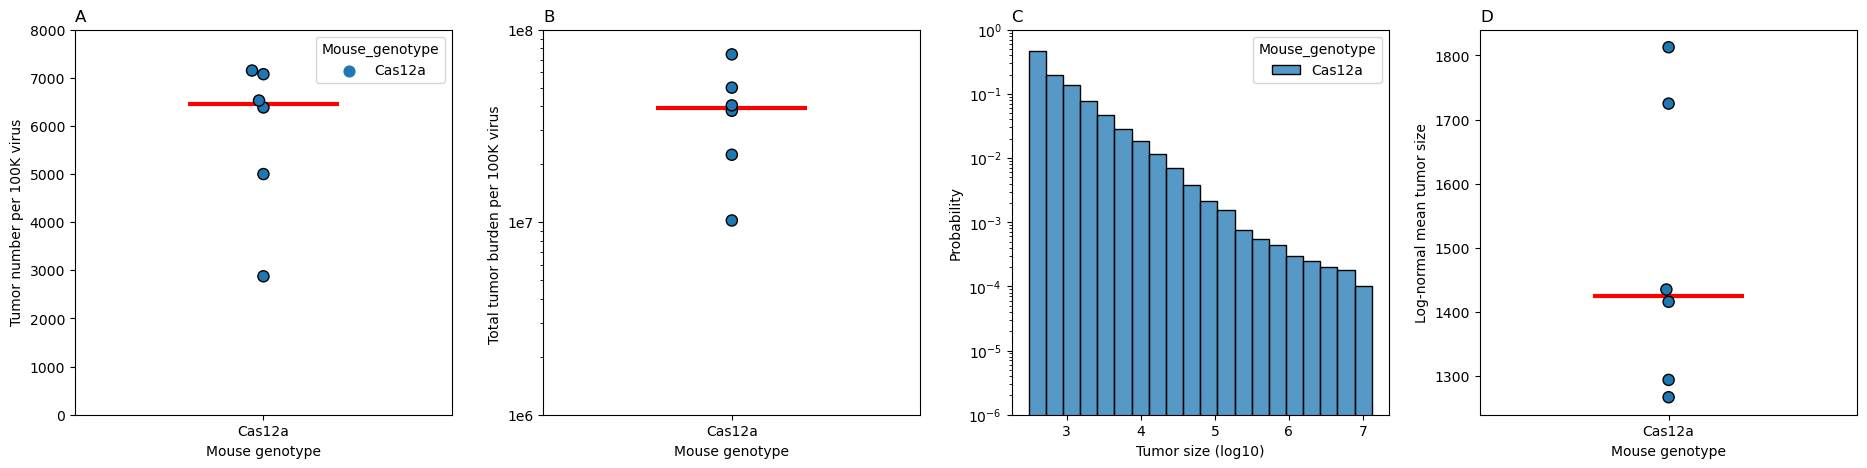

In [42]:
gs = gridspec.GridSpec(10, 23) 
fig1 = plt.figure(figsize=(23,5))
ax1=fig1.add_subplot(gs[:10, 0:5])
temp_p_df = temp_summary_df.sort_values(by='Mouse_genotype')
temp_p_df = temp_p_df[temp_p_df.Mouse_genotype=='Cas12a']
ix = 'Mouse_genotype'
iy = 'Tumor number per 100K virus'
# panel A
# dot plot
sns.swarmplot(x=ix, y=iy, data=temp_p_df,
              ax=ax1, size=8,hue='Mouse_genotype',edgecolor="black", linewidth=1)

# add mean line
category_means = temp_p_df.groupby(ix)[iy].median().reset_index()
# Loop through each category and draw a horizontal line for its mean
for index, row in category_means.iterrows():
    # Get the positions of the x-ticks
    xticks = ax1.get_xticks()
    if row[ix] in temp_p_df[ix].values:
        # Find the position of the current category in the x-ticks
        ix_position = list(temp_p_df[ix].unique()).index(row[ix])
        # Draw a horizontal line for this category's mean
        ax1.hlines(row[iy], xticks[ix_position] - 0.2, xticks[ix_position] + 0.2, color='r', linestyle='-',linewidth=3)

# set labels
ax1.set_ylabel('Tumor number per 100K virus')
ax1.set_xlabel('Mouse genotype')

# ax1.text(0.8,1.05, "$\it{p-value}$ =" + f" {temp[1]:.3f}", size=10, ha="right",verticalalignment='center', transform=ax1.transAxes)
ax1.set_ylim(0,8000)
ax1.set_title('A', loc ='Left')
ax1.yaxis.set_minor_locator(plt.NullLocator())
# ax1.get_legend().set_visible(False)

# panel B
ax1=fig1.add_subplot(gs[:10, 6:11])
ix = 'Mouse_genotype'
iy = 'Total tumor burden per 100K virus'
sns.swarmplot(x=ix, y=iy, data=temp_p_df,
              ax=ax1, size=8,hue='Mouse_genotype',edgecolor="black", linewidth=1)
# add mean line
category_means = temp_p_df.groupby(ix)[iy].median().reset_index()
# Loop through each category and draw a horizontal line for its mean
for index, row in category_means.iterrows():
    # Get the positions of the x-ticks
    xticks = ax1.get_xticks()
    if row[ix] in temp_p_df[ix].values:
        # Find the position of the current category in the x-ticks
        ix_position = list(temp_p_df[ix].unique()).index(row[ix])
        # Draw a horizontal line for this category's mean
        ax1.hlines(row[iy], xticks[ix_position] - 0.2, xticks[ix_position] + 0.2, color='r', linestyle='-',linewidth=3)
# labels
ax1.set_ylabel('Total tumor burden per 100K virus ')
ax1.set_xlabel('Mouse genotype')
ax1.set_ylim(1000000,100000000)
ax1.set_yscale('log',base = 10)
temp_ticks_list=ax1.get_yticks()
# ax1.set_yticklabels([round(x) for x in temp_ticks_list])
# # ax1.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
# ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'${int(x):.0e}$'))

tick_locs = [1e6, 1e7, 1e8]  # Locations where you want the ticks to be
tick_lbls = ['1e6','1e7', '1e8']  # Corresponding labels for these locations

ax1.set_yticks(tick_locs)  # Set the locations of the y-axis ticks
ax1.set_yticklabels(tick_lbls)  # Set the labels of the y-axis ticks

ax1.set_title('B', loc ='Left')
ax1.get_legend().set_visible(False)

# panel C
ax1=fig1.add_subplot(gs[:10, 12:17])
temp_p_df3 = Filtered_input_df.copy().sort_values(by='Mouse_genotype')
temp_p_df3['Log10_CN'] = np.log10(temp_p_df3['Cell_number'] )
temp_p_df3 = temp_p_df3[temp_p_df3.Mouse_genotype=='Cas12a']
ix = 'Log10_CN'
sns.histplot(data=temp_p_df3, x=ix, hue="Mouse_genotype", bins=20,
                  common_norm=False, stat="probability", multiple="dodge", log_scale=(False, True),ax=ax1)
ax1.set_ylim(1e-6,1)
# ax1.get_legend().set_visible(False) 
ax1.set_xlabel('Tumor size (log10)')
ax1.set_ylabel('Probability')
ax1.set_title('C', loc ='Left')
# panel D
ax1=fig1.add_subplot(gs[:10, 18:23])
ix = 'Mouse_genotype'
iy = 'LN_mean_tumor_size'

sns.swarmplot(x=ix, y=iy, data=temp_p_df,
              ax=ax1, size=8,hue='Mouse_genotype',edgecolor="black", linewidth=1)
# add mean line
category_means = temp_p_df.groupby(ix)[iy].median().reset_index()
# Loop through each category and draw a horizontal line for its mean
for index, row in category_means.iterrows():
    # Get the positions of the x-ticks
    xticks = ax1.get_xticks()
    if row[ix] in temp_p_df[ix].values:
        # Find the position of the current category in the x-ticks
        ix_position = list(temp_p_df[ix].unique()).index(row[ix])
        # Draw a horizontal line for this category's mean
        ax1.hlines(row[iy], xticks[ix_position] - 0.2, xticks[ix_position] + 0.2, color='r', linestyle='-',linewidth=3)
# sns.violinplot(data=temp_df2, x=ix, y=iy, ax=ax1, inner="points")
ax1.set_ylabel('Log-normal mean tumor size')
ax1.set_xlabel('Mouse genotype')
ax1.get_legend().set_visible(False) 
ax1.set_title('D', loc ='Left')

----

## 6 Plotting for PADC

<font size="10" color="red"> Fig. 5(g-h) and S3 (c-d)</font>

### 6.1 Datat processing

In [64]:
input_df = PDAC_df
cell_cutoff = 300
input_tissue = 'Pancreas'
Filtered_input_df = input_df[(input_df.Class=='Original')&(input_df.Cell_number>cell_cutoff)&(input_df.Tissue=='Pancreas')&(~input_df.Sample_ID.str.contains('B'))].copy()
temp_dic = virus_dic

* <font size="5" color='red'> I extroplate tumor number and burden </font>

In [65]:
temp_df = copy.deepcopy(Filtered_input_df)
temp_summary_df = temp_df.groupby(['Sample_ID','Mouse_genotype'],as_index=False).agg(
        Total_tumor_number = pd.NamedAgg('Clonal_barcode',aggfunc ='count'),
        TTB = pd.NamedAgg('Cell_number',aggfunc = np.sum),
        LN_mean_tumor_size = pd.NamedAgg('Cell_number',aggfunc = LN_Mean),
        Median_tumor_size = ('Cell_number',lambda x: np.median(x)),
        P95_tumor_size = ('Cell_number',lambda x: np.percentile(x,95))
)
temp = temp_df[['Sample_ID','Total_lung_weight','Lung_sample_weight']].drop_duplicates()

# factor into the fact that frozen tissue weight and total lung weight is different
temp_fold_dic = dict(zip(temp.Sample_ID,temp.Total_lung_weight/temp.Lung_sample_weight))
temp_summary_df['Total_tumor_number'] = temp_summary_df.apply(lambda x: x['Total_tumor_number']*temp_fold_dic.get(x['Sample_ID']),axis=1)
temp_summary_df['TTB'] = temp_summary_df.apply(lambda x: x['TTB']*temp_fold_dic.get(x['Sample_ID']),axis=1)

In [66]:
# normalize to per 100K virus
temp_summary_df['Tumor number per 100K virus'] = temp_summary_df.apply(lambda x: x['Total_tumor_number']/temp_dic.get(x['Mouse_genotype']),axis=1)
temp_summary_df['Total tumor burden per 100K virus (log10)'] = np.log10(temp_summary_df.apply(lambda x: x['TTB']/temp_dic.get(x['Mouse_genotype']),axis=1))

### 6.2 Plotting

/var/folders/xv/26kbh4lj2rjdcrxz37m9wxyw0000gn/T/ipykernel_54708/2274653636.py:35: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_yticklabels([round(x) for x in temp_ticks_list])
/var/folders/xv/26kbh4lj2rjdcrxz37m9wxyw0000gn/T/ipykernel_54708/2274653636.py:111: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_yticklabels([round(x) for x in temp_ticks_list])


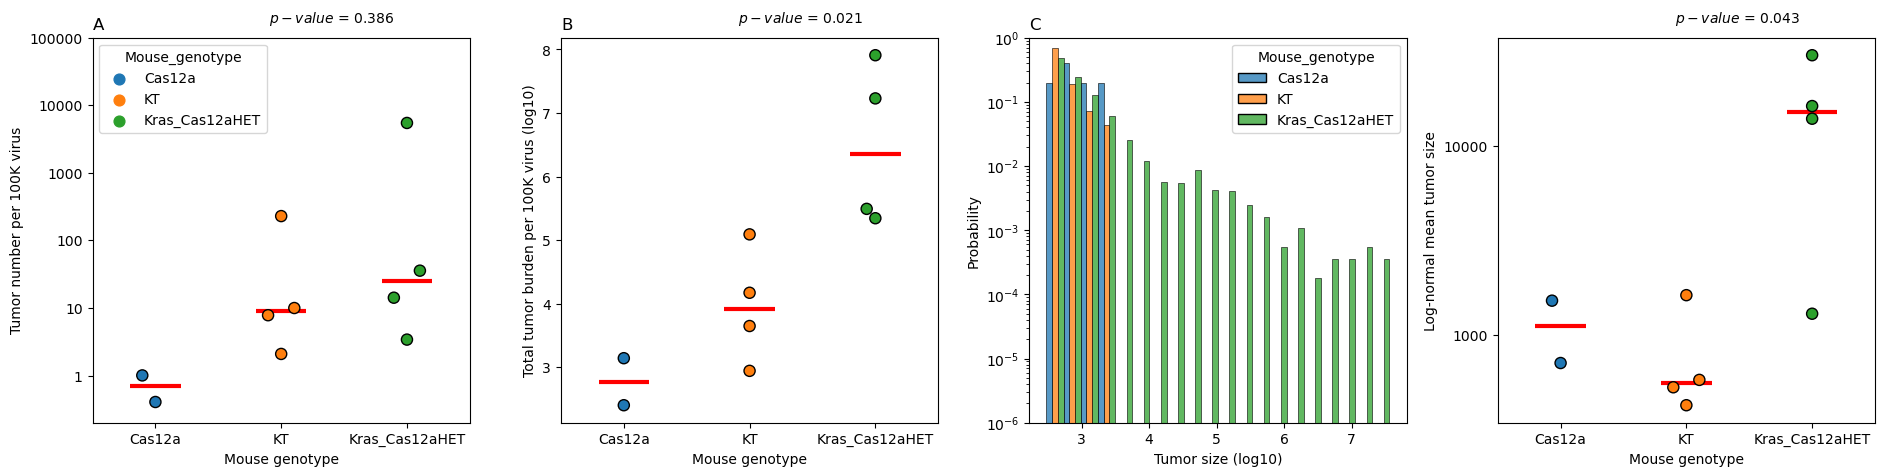

In [67]:
gs = gridspec.GridSpec(10, 23) 
fig1 = plt.figure(figsize=(23,5))
ax1=fig1.add_subplot(gs[:10, 0:5])
temp_p_df = temp_summary_df.sort_values(by='Mouse_genotype')
ix = 'Mouse_genotype'
iy = 'Tumor number per 100K virus'
# panel A
# dot plot
sns.swarmplot(x=ix, y=iy, data=temp_p_df,
              ax=ax1, size=8,hue='Mouse_genotype',edgecolor="black", linewidth=1)

# add mean line
category_means = temp_p_df.groupby(ix)[iy].median().reset_index()
# Loop through each category and draw a horizontal line for its mean
for index, row in category_means.iterrows():
    # Get the positions of the x-ticks
    xticks = ax1.get_xticks()
    if row[ix] in temp_p_df[ix].values:
        # Find the position of the current category in the x-ticks
        ix_position = list(temp_p_df[ix].unique()).index(row[ix])
        # Draw a horizontal line for this category's mean
        ax1.hlines(row[iy], xticks[ix_position] - 0.2, xticks[ix_position] + 0.2, color='r', linestyle='-',linewidth=3)

# set labels
ax1.set_ylabel('Tumor number per 100K virus')
ax1.set_xlabel('Mouse genotype')
da1 = temp_p_df[temp_p_df.Mouse_genotype=='Kras_Cas12aHET'][iy].to_list()
da2 = temp_p_df[temp_p_df.Mouse_genotype=='KT'][iy].to_list()
temp = SS.ranksums(da1,da2)
# temp = SS.ttest_ind(da1, da2)
ax1.text(0.8,1.05, "$\it{p-value}$ =" + f" {temp[1]:.3f}", size=10, ha="right",verticalalignment='center', transform=ax1.transAxes)
ax1.set_ylim(.2,100000)
ax1.set_yscale('log',base = 10)
temp_ticks_list=ax1.get_yticks()
ax1.set_yticklabels([round(x) for x in temp_ticks_list])
ax1.set_title('A', loc ='Left')
ax1.yaxis.set_minor_locator(plt.NullLocator())
# ax1.get_legend().set_visible(False)

# panel B
ax1=fig1.add_subplot(gs[:10, 6:11])
ix = 'Mouse_genotype'
iy = 'Total tumor burden per 100K virus (log10)'
sns.swarmplot(x=ix, y=iy, data=temp_p_df,
              ax=ax1, size=8,hue='Mouse_genotype',edgecolor="black", linewidth=1)
# add mean line
category_means = temp_p_df.groupby(ix)[iy].median().reset_index()
# Loop through each category and draw a horizontal line for its mean
for index, row in category_means.iterrows():
    # Get the positions of the x-ticks
    xticks = ax1.get_xticks()
    if row[ix] in temp_p_df[ix].values:
        # Find the position of the current category in the x-ticks
        ix_position = list(temp_p_df[ix].unique()).index(row[ix])
        # Draw a horizontal line for this category's mean
        ax1.hlines(row[iy], xticks[ix_position] - 0.2, xticks[ix_position] + 0.2, color='r', linestyle='-',linewidth=3)
# labels
ax1.set_ylabel('Total tumor burden per 100K virus (log10)')
ax1.set_xlabel('Mouse genotype')
da1 = temp_p_df[temp_p_df.Mouse_genotype=='Kras_Cas12aHET'][iy].to_list()
da2 = temp_p_df[temp_p_df.Mouse_genotype=='KT'][iy].to_list()
temp = SS.ranksums(da1,da2)
# temp = SS.ttest_ind(da1, da2)
ax1.text(0.8,1.05, "$\it{p-value}$ =" + f" {temp[1]:.3f}", size=10, ha="right",verticalalignment='center', transform=ax1.transAxes)
# ax1.set_ylim(0,10)
ax1.set_title('B', loc ='Left')
ax1.get_legend().set_visible(False)

# panel C
ax1=fig1.add_subplot(gs[:10, 12:17])
temp_p_df3 = Filtered_input_df.copy().sort_values(by='Mouse_genotype')
temp_p_df3['Log10_CN'] = np.log10(temp_p_df3['Cell_number'] )
ix = 'Log10_CN'
sns.histplot(data=temp_p_df3, x=ix, hue="Mouse_genotype", bins=20,
                  common_norm=False, stat="probability", multiple="dodge", log_scale=(False, True),ax=ax1)
ax1.set_ylim(1e-6,1)
# ax1.get_legend().set_visible(False) 
ax1.set_xlabel('Tumor size (log10)')
ax1.set_ylabel('Probability')
ax1.set_title('C', loc ='Left')
# # panel D
ax1=fig1.add_subplot(gs[:10, 18:23])
ix = 'Mouse_genotype'
iy = 'LN_mean_tumor_size'

sns.swarmplot(x=ix, y=iy, data=temp_p_df,
              ax=ax1, size=8,hue='Mouse_genotype',edgecolor="black", linewidth=1)
# add mean line
category_means = temp_p_df.groupby(ix)[iy].median().reset_index()
# Loop through each category and draw a horizontal line for its mean
for index, row in category_means.iterrows():
    # Get the positions of the x-ticks
    xticks = ax1.get_xticks()
    if row[ix] in temp_p_df[ix].values:
        # Find the position of the current category in the x-ticks
        ix_position = list(temp_p_df[ix].unique()).index(row[ix])
        # Draw a horizontal line for this category's mean
        ax1.hlines(row[iy], xticks[ix_position] - 0.2, xticks[ix_position] + 0.2, color='r', linestyle='-',linewidth=3)
# sns.violinplot(data=temp_df2, x=ix, y=iy, ax=ax1, inner="points")
ax1.set_ylabel('Log-normal mean tumor size')
ax1.set_xlabel('Mouse genotype')
da1 = temp_p_df[temp_p_df.Mouse_genotype=='Kras_Cas12aHET'][iy].to_list()
da2 = temp_p_df[temp_p_df.Mouse_genotype=='KT'][iy].to_list()
# SS.ranksums(da1,da2)
temp = SS.ranksums(da1,da2)
# temp = SS.ttest_ind(da1, da2)
ax1.text(0.8,1.05, "$\it{p-value}$ =" + f" {temp[1]:.3f}", size=10, ha="right",verticalalignment='center', transform=ax1.transAxes)
# ax1.set_ylim(0,5000)
ax1.set_yscale('log',base = 10)
temp_ticks_list=ax1.get_yticks()
ax1.set_yticklabels([round(x) for x in temp_ticks_list])
ax1.yaxis.set_minor_locator(plt.NullLocator())
ax1.get_legend().set_visible(False) 
# ax1.yaxis.set_label_position("right")
# ax1.yaxis.tick_right()
labels = ax1.get_xticklabels()  # Get current labels
# ax1.set_xticklabels(labels, rotation=45)

# fig1.savefig(temp_out_address)